# Approach 3 (Specific Companies Only)

**Idea:** Since what we are really after is just the ‘difference’ in hierarchy across firms, and not necessarily in classifying specific jobs into specific levels, what we can try to do instead is to use job title variance as a proxy for hierarchy. Specifically, we can see if we can use the occupational codes as a starting point for classifying functions in a firm (a very rough proxy of course), and then clean the titles within each occupation to get rid of any noise. We can then treat the variation in titles within an occupation as likely indicative of either: (1) differences in hierarchical levels, or (2) differences in divisions. Once we have these lists for each firm, we can see if we can construct some algorithm or use human coders to separate out the two dimensions. 

> The end goal is to pick out, for each firm, the occupations with the longest list of unique job titles and use these occupations to tell us the likely maximum length of vertical hierarchy and the likely maximum number of divisions in this firm.

## Assumptions: 
1. Does BG capture occupations accurately? How to check: how many different occupations are there in any given firm?
2. Do occupations overlap with functions? (CanonJobTitle)
3. Check distributions of job titles within each occupation: check whether job titles within occupations vary mostly vertically
4. Do we observe skills variation across occupations (=divisions)? Can we use the skill variation to capture product differentiation?
5. Are we able to capture function names & geography names?

## Steps: 
1. Identify all unique job titles for each firm and count them
2. Identify all unique occupations for each firm and count them
3. Say we get 20 job titles and 5 occupations, and we know how many job titles are in each occupation
4. We assume that occupation = division (obviously very very crude, but bear with me) 
5. We assume titles within occupations differ only in level on the org chart
6. We then take the occupation with the largest number of unique titles and use that number as the total number of firm layers

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit, njit, vectorize
from glob import glob
import re
import seaborn as sns
import pickle
import joblib
import nltk

import concurrent.futures

pd.set_option('display.max_columns', None) 

%matplotlib inline

In [2]:
dtypes={'JobID': np.str, 'CleanJobTitle': np.str, 'JobDomain': np.str, 
        'CanonCity': np.str, 'CanonCountry': np.str, 'CanonState': np.str, 
        'JobText': np.str, 'JobURL': np.str, 'PostingHTML': np.float64, 
        'Source': np.str, 'JobReferenceID': np.str, 'Email': np.str, 
        'CanonEmployer': np.str, 'Latitude': np.str, 'Longitude': np.str, 
        'CanonIntermediary': np.str, 'Telephone': np.str, 'CanonJobTitle': 'object', 
        'CanonCounty': np.str, 'DivisionCode': np.float64, 'MSA': np.str, 'LMA': np.str,
        'InternshipFlag': np.str, 'ConsolidatedONET': np.str, 'CanonCertification': np.str, 
        'CanonSkillClusters': np.str, 'CanonSkills': np.str, 'IsDuplicate': np.str, 
        'IsDuplicateOf': np.float64, 'CanonMaximumDegree': np.str, 'CanonMinimumDegree': np.str, 
        'CanonOtherDegrees': np.str, 'CanonPreferredDegrees': np.str,
        'CanonRequiredDegrees': np.str, 'CIPCode': np.str, 'StandardMajor': np.str, 
        'MaxExperience': np.float64, 'MinExperience': np.float64, 'ConsolidatedInferredNAICS': np.float64, 
        'BGTOcc': np.str, 'MaxAnnualSalary': np.float64, 'MaxHourlySalary': np.float64, 
        'MinAnnualSalary': np.float64, 'MinHourlySalary': np.float64, 'YearsOfExperience': np.str, 
        'CanonJobHours': np.str, 'CanonJobType': np.str, 'CanonPostalCode': np.str, 
        'CanonYearsOfExperienceCanonLevel': np.str, 'CanonYearsOfExperienceLevel': np.str, 
        'ConsolidatedTitle': np.str, 'Language': np.str, 'BGTSubOcc': np.str, 'JobDate': np.str,
        'ConsolidatedDegreeLevels': np.str, 'MaxDegreeLevel': np.float64, 'MinDegreeLevel': np.float64
                       }

## Data

We will be using the combined dataset we saved in during Approach 2, which contains the matched occupations to each one of the companies.

In [3]:
%%time

df = pd.read_csv('~/Dropbox/Burning Glass/Data/comps_occupations_merged.csv',
                 low_memory=False, parse_dates=['JobDate'], dtype=dtypes)

# Concatenate all of the datasets into one
df.reset_index(drop=True, inplace=True)
df.head(3)

CPU times: user 23.9 s, sys: 19.2 s, total: 43.2 s
Wall time: 1min 3s


,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience,occu_code,occu_text
0,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
1,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.7019,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons
2,412031,Retail Sales Associate (General),Arlington Heights,Cook,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,IL,mid,Automotive Sales Associate,336111.0,41203100,Sales Associate,16974.0,2017-03-13,38195316884,Automotive Sales Associate\n\nArlington Height...,DV171697|MT171698,41.8792,-87.9747,16980: Metropolitan Statistical Area|176: Comb...,3.0,412031,Retail Salespersons


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540143 entries, 0 to 540142
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   BGTOcc                       540143 non-null  object        
 1   BGTSubOcc                    540122 non-null  object        
 2   CanonCity                    535037 non-null  object        
 3   CanonCounty                  533867 non-null  object        
 4   CanonEmployer                540143 non-null  object        
 5   CanonJobHours                303355 non-null  object        
 6   CanonJobTitle                366347 non-null  object        
 7   CanonJobType                 304541 non-null  object        
 8   CanonSkillClusters           532116 non-null  object        
 9   CanonSkills                  540143 non-null  object        
 10  CanonState                   540126 non-null  object        
 11  CanonYearsOfExperienceLeve

We will define a path for saving the output of all assumptions in approach 2 below.

In [6]:
path_assumptions = '/Users/ramonperez/Dropbox/Burning Glass/Analysis/approach_2/'

# The first three assumptions in Approach 3 can be found in Approach 2.

## Assumptions 1
> Does BG capture occupations accurately?

How to check --> how many different occupations are there in any given firm?

## Assumptions 2

> Do occupations overlap with functions? (CanonJobTitle)

## Assumptions 3

> Check distributions of job titles within each occupation: check whether job titles within occupations vary mostly vertically

## Assumptions 4

> Do we observe skills variation across occupations (=divisions)? Can we use the skill variation to capture product differentiation?

1. Most common skills found in all jobs within an occupation
    - Top 20
    - Bottom 20
2. Skills per CanonYearsOfExperienceLevel
3. Variation of skills at different levels and within similar companies, for example, top 20 skills in a high-level job at McKinsey and BCG

In [7]:
import ast
from typing import List
from pprint import pprint

In [8]:
pprint(ast.literal_eval(df['CanonSkills'][0]).values())

dict_values(['Sales: Specialized Sales;Specialized Skills', 'Specialized Skills', 'Marketing and Public Relations: Marketing Software;Specialized Skills', 'Customer and Client Support: Basic Customer Service;Specialized Skills', 'Sales: Inside Sales;Specialized Skills', 'Sales: Outside Sales;Specialized Skills', 'Specialized Skills', 'Sales: Retail Sales;Specialized Skills', 'Sales: General Sales;Specialized Skills', 'Specialized Skills'])


In [9]:
def clean_skill_keys(data: str) -> List[str]:
    temp = ast.literal_eval(data)
    return list(temp.keys())

def clean_skill_values(data: str) -> List[str]:
    temp = ast.literal_eval(data)
    return list(temp.values())

In [10]:
%%time

df['clean_skill_keys'] = df['CanonSkills'].apply(lambda x: clean_skill_keys(x))
df['clean_skill_values'] = df['CanonSkills'].apply(lambda x: clean_skill_values(x))
df[['clean_skill_keys', 'clean_skill_values']].head()

CPU times: user 51.7 s, sys: 3.54 s, total: 55.2 s
Wall time: 57 s


,clean_skill_keys,clean_skill_values
0,"[Automotive Sales, Business-to-Business, Busin...","[Sales: Specialized Sales;Specialized Skills, ..."
1,"[Automotive Sales, Communication Skills, Custo...","[Sales: Specialized Sales;Specialized Skills, ..."
2,"[Automotive Sales, Communication Skills, Custo...","[Sales: Specialized Sales;Specialized Skills, ..."
3,"[Automotive Sales, Communication Skills, Custo...","[Sales: Specialized Sales;Specialized Skills, ..."
4,"[Buying Experience, Customer Service, Product ...",[Supply Chain and Logistics: Procurement;Speci...


In [11]:
df['clean_skill_keys'][0]

['Automotive Sales',
 'Business-to-Business',
 'Business-to-Business Sales',
 'Customer Service',
 'Inside Sales',
 'Outside Sales',
 'Retail Industry Knowledge',
 'Retail Sales',
 'Sales',
 'Self-Starter']

In [12]:
df['clean_skill_values'][0]

['Sales: Specialized Sales;Specialized Skills',
 'Specialized Skills',
 'Marketing and Public Relations: Marketing Software;Specialized Skills',
 'Customer and Client Support: Basic Customer Service;Specialized Skills',
 'Sales: Inside Sales;Specialized Skills',
 'Sales: Outside Sales;Specialized Skills',
 'Specialized Skills',
 'Sales: Retail Sales;Specialized Skills',
 'Sales: General Sales;Specialized Skills',
 'Specialized Skills']

In [13]:
df['clean_skill_values'].str[0].head(15)

0           Sales: Specialized Sales;Specialized Skills
1           Sales: Specialized Sales;Specialized Skills
2           Sales: Specialized Sales;Specialized Skills
3           Sales: Specialized Sales;Specialized Skills
4     Supply Chain and Logistics: Procurement;Specia...
5     Supply Chain and Logistics: Procurement;Specia...
6     Administration: Administrative Support;Special...
7                                    Specialized Skills
8                                    Specialized Skills
9                                    Specialized Skills
10          Sales: Specialized Sales;Specialized Skills
11    Administration: Administrative Support;Special...
12    Administration: Administrative Support;Special...
13                                   Specialized Skills
14                                   Specialized Skills
Name: clean_skill_values, dtype: object

Average amount of skills (as the key) per job found.

In [60]:
print(df['clean_skill_keys'].apply(len).describe())
print()
print(df['clean_skill_values'].apply(len).describe())

count    540143.000000
mean         12.387899
std           7.757378
min           0.000000
25%           7.000000
50%          12.000000
75%          17.000000
max         235.000000
Name: clean_skill_keys, dtype: float64

count    540143.000000
mean         12.387899
std           7.757378
min           0.000000
25%           7.000000
50%          12.000000
75%          17.000000
max         235.000000
Name: clean_skill_values, dtype: float64


Let's create a list of all of the skills in the dataset and keep all unique skills available. We will use both, the keys and the values already available in the dataset.

In [49]:
skills_keys_list = []
skills_values_list = []

for skill_k in df['clean_skill_keys']:
    skills_keys_list.extend(skill_k)

for skill_v in df['clean_skill_values']:
    skills_values_list.extend(skill_v)


Here is the amount of skills found in the dataset **including** duplicates.

In [50]:
len(skills_keys_list), len(skills_values_list)

(6691237, 6691237)

Here is the amount of skills found in the dataset **without** duplicates.

In [51]:
len(set(skills_keys_list)), len(set(skills_values_list))

(7723, 500)

In [52]:
set_of_key_skills = set(skills_keys_list)
set_of_value_skills = set(skills_values_list)

In [105]:
df.head(2)

,BGTOcc,BGTSubOcc,CanonCity,CanonCounty,CanonEmployer,CanonJobHours,CanonJobTitle,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,JobDate,JobID,JobText,LMA,Latitude,Longitude,MSA,MinExperience,occu_code,occu_text,cleaning_skills,clean_skill_keys,clean_skill_values,len_of_skills
0,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-25,38201188919,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",MC011930,30.3962,-87.701897,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons,{'Automotive Sales': 'Sales: Specialized Sales...,"[Automotive Sales, Business-to-Business, Busin...","[Sales: Specialized Sales;Specialized Skills, ...",10
1,412031,Retail Sales Associate (General),Foley,Baldwin,Chrysler,fulltime,Sales Associate,permanent,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,Automotive Sales Associate,336111.0,41203100,Sales Associate,NaN,2017-03-24,38200222343,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",MC011930,30.3962,-87.701897,19300: Metropolitan Statistical Area,NaN,412031,Retail Salespersons,{'Automotive Sales': 'Sales: Specialized Sales...,"[Automotive Sales, Communication Skills, Custo...","[Sales: Specialized Sales;Specialized Skills, ...",9


In [53]:
df['len_of_skills'] = df['clean_skill_keys'].apply(len)
df['len_of_skills'].head()

0    10
1     9
2     5
3     5
4     4
Name: len_of_skills, dtype: int64

In [61]:
skill_per_occu = df.groupby('occu_text')
skill_per_occu['len_of_skills'].agg('sum').head(20)

occu_text
Accountants and Auditors                                                     141038
Actuaries                                                                      1021
Adult Basic and Secondary Education and Literacy Teachers and Instructors        28
Advertising Sales Agents                                                        604
Aerospace Engineers                                                            5882
Agricultural and Food Science Technicians                                       440
Aircraft Mechanics and Service Technicians                                     6470
Amusement and Recreation Attendants                                             278
Animal Control Workers                                                         1332
Animal Trainers                                                                  18
Appraisers and Assessors of Real Estate                                        1228
Architects, Except Landscape and Naval                            

In [63]:
occups = list(df['occu_text'].unique())
occups[:3]

['Retail Salespersons',
 'Cleaners of Vehicles and Equipment',
 'Automotive Service Technicians and Mechanics']

In [88]:
df.loc[df['occu_text'] == 'Retail Salespersons', 'clean_skill_keys'].head()

0    [Automotive Sales, Business-to-Business, Busin...
1    [Automotive Sales, Communication Skills, Custo...
2    [Automotive Sales, Communication Skills, Custo...
3    [Automotive Sales, Communication Skills, Custo...
4    [Buying Experience, Customer Service, Product ...
Name: clean_skill_keys, dtype: object

In [85]:
def is_it_there(words_list, word):
    if word in words_list:
        return True
    else:
        return False

In [87]:
is_it_there(df.loc[df['occu_text'] == 'Retail Salespersons', 'clean_skill_keys'][0], 'Automotive Sales')

True

In [98]:
df_tiny = df.sample(30).copy()

In [99]:
matr = np.empty((len(df_tiny), 1))
empty_df_skills = pd.DataFrame(matr)
empty_df_occu = pd.DataFrame(matr)
empty_df_skills.head()

,0
0,1.976263e-323
1,1.976263e-323
2,1.976263e-323
3,1.976263e-323
4,1.976263e-323


In [ ]:
%%time

# appearance = {}
# app_dict = {}


for skill in skill_set_list:
        empty_df_skills[skill] = df_tiny.loc[:, 'clean_skill_keys'].apply(lambda x: is_it_there(x, skill))
#     appearance[occu] += app_dict

In [ ]:
def get_count(x):
    return len(x)

In [ ]:
empty_df_skills.head()

In [94]:
%%time

appearance = {}
app_dict = {}


for occu in occups:
#     to_sum = []
    for skill in skill_set_list:
        app_dict[skill] = df_tiny.loc[df_tiny['occu_text'] == occu, 'clean_skill_keys'].apply(lambda x: is_it_there(x, skill)).sum()
    appearance[occu] += app_dict
#         df[occu] = df[occu].apply(int)
#             app_dict[occu] += 1
#             to_sum.append(skill)
#         else:
#     appearance.append(to_sum)

KeyboardInterrupt: 

In [75]:
a_Ser = pd.Series([1, 2, 3])
a_Ser += pd.Series([1, 2, 3])
a_Ser

0    2
1    4
2    6
dtype: int64

## Assumptions 5

> Are we able to capture function names & geography names?

Additions
1. Skills per state
    - Top 20
    - Bottom 20
2. Skills per county

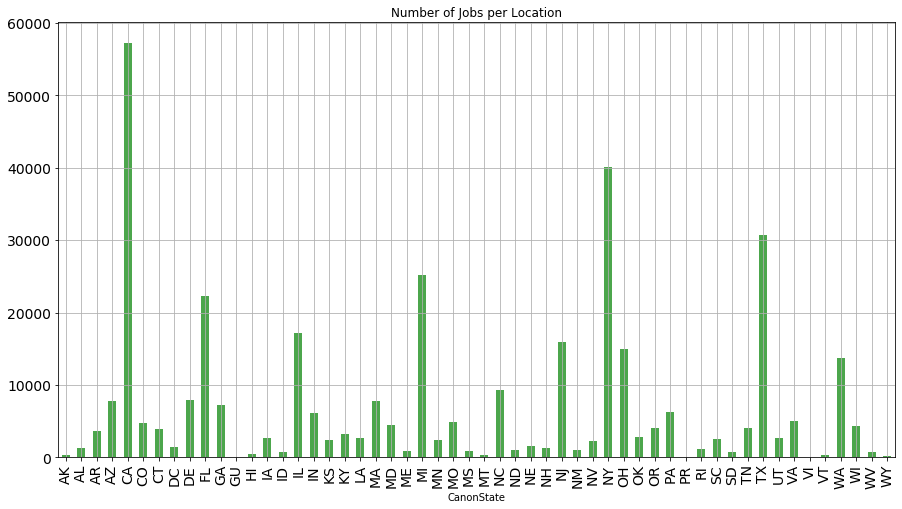

In [28]:
states = df.groupby('CanonState')
states['CanonJobTitle'].count().plot(kind='bar',
                                     rot=90, 
                                     figsize=(15, 8),
                                     color='green',
                                     fontsize=14,
                                     title='Number of Jobs per Location',
                                     grid=True,
                                     alpha=0.70);

In [34]:
df.dtypes

BGTOcc                                 object
BGTSubOcc                              object
CanonCity                              object
CanonCounty                            object
CanonEmployer                          object
CanonJobHours                          object
CanonJobTitle                          object
CanonJobType                           object
CanonSkillClusters                     object
CanonSkills                            object
CanonState                             object
CanonYearsOfExperienceLevel            object
CleanJobTitle                          object
ConsolidatedInferredNAICS             float64
ConsolidatedONET                       object
ConsolidatedTitle                      object
DivisionCode                          float64
JobDate                        datetime64[ns]
JobID                                  object
JobText                                object
LMA                                    object
Latitude                          

In [38]:
df['Longitude'] = df['Longitude'].astype(np.float32)
df['Latitude'] = df['Latitude'].astype(np.float32)

In [41]:
import bokeh
bokeh.sampledata.download()

Creating /Users/ramonperez/.bokeh directory
Creating /Users/ramonperez/.bokeh/data directory
Using data directory: /Users/ramonperez/.bokeh/data
Downloading: CGM.csv (1589982 bytes)
   1589982 [100.00%]
Downloading: US_Counties.zip (3171836 bytes)
   3171836 [100.00%]
Unpacking: US_Counties.csv
Downloading: us_cities.json (713565 bytes)
    713565 [100.00%]
Downloading: unemployment09.csv (253301 bytes)
    253301 [100.00%]
Downloading: AAPL.csv (166698 bytes)
    166698 [100.00%]
Downloading: FB.csv (9706 bytes)
      9706 [100.00%]
Downloading: GOOG.csv (113894 bytes)
    113894 [100.00%]
Downloading: IBM.csv (165625 bytes)
    165625 [100.00%]
Downloading: MSFT.csv (161614 bytes)
    161614 [100.00%]
Downloading: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip (4816256 bytes)
   4816256 [100.00%]
Unpacking: WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.csv
Downloading: gapminder_fertility.csv (64346 bytes)
     64346 [100.00%]
Downloading: gapminder_population.csv (94509 bytes)
     94509 [10

In [42]:
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment

In [48]:
states['NV']

{'name': 'Nevada',
 'region': 'Southwest',
 'lats': [40.68928,
  40.4958,
  40.30302,
  40.09896,
  39.99994,
  39.75817,
  39.61018,
  39.45715,
  39.36296,
  39.23851,
  39.08777,
  38.90545,
  38.75165,
  38.55049,
  38.20495,
  37.95499,
  37.77873,
  37.70735,
  37.47222,
  37.13439,
  37.0004,
  36.99997,
  36.817,
  36.60322,
  36.37619,
  36.21464,
  36.09833,
  36.01461,
  36.10119,
  36.15058,
  36.11546,
  36.05493,
  35.98542,
  35.9167,
  35.86436,
  35.81412,
  35.73579,
  35.66942,
  35.60517,
  35.5417,
  35.49125,
  35.37012,
  35.21811,
  35.14231,
  35.11791,
  35.07971,
  35.00332,
  35.00186,
  35.00195,
  35.15341,
  35.38796,
  35.59033,
  35.81231,
  36.0018,
  36.14577,
  36.37205,
  36.75057,
  37.08441,
  37.43715,
  37.6185,
  37.75309,
  37.96065,
  38.30368,
  38.60904,
  38.83427,
  38.98156,
  39.37557,
  39.57782,
  39.79567,
  40.08934,
  40.39719,
  40.86934,
  41.26742,
  41.97905,
  41.99454,
  41.99484,
  41.9972,
  41.99746,
  41.99621,
  41.99594

In [ ]:


# del states["HI"]
# del states["AK"]

# EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")

# state_xs = list(df['Longitude'].values())
# state_ys = list(df['Latitude'].values())

# county_xs=[counties[code]["lons"] for code in counties if counties[code]["state"] not in EXCLUDED]
# county_ys=[counties[code]["lats"] for code in counties if counties[code]["state"] not in EXCLUDED]

# colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]

# county_colors = []
# for county_id in counties:
#     if counties[county_id]["state"] in EXCLUDED:
#         continue
#     try:
#         rate = unemployment[county_id]
#         idx = int(rate/6)
#         county_colors.append(colors[idx])
#     except KeyError:
#         county_colors.append("black")

p = figure(title="US Unemployment 2009", toolbar_location="left",
           plot_width=1100, plot_height=700)

p.patches(df.loc[''], county_ys,
          fill_color=county_colors, fill_alpha=0.7,
          line_color="white", line_width=0.5)

p.patches(state_xs, state_ys, fill_alpha=0.0,
          line_color="#884444", line_width=2, line_alpha=0.3)

output_file("choropleth.html", title="choropleth.py example")

show(p)

In [18]:
jobs_count = df.groupby('CanonJobTitle')['CanonJobTitle'].count()
jobs_count.head()

CanonJobTitle
.Net Application Developer     56
.Net Architect                 15
.Net Developer                463
.Net Programmer                37
.Net Team Lead                  4
Name: CanonJobTitle, dtype: int64

In [ ]:
occu_count = df.groupby('CanonJobTitle')['CanonJobTitle'].count()
occu_count.head()